In [136]:
import numpy
import scipy
import matplotlib.pyplot as plt

dt    = 0.1

mat_a = numpy.zeros((1, 1))
mat_b = numpy.zeros((1, 1))

tau = 15.0
amp = 1.0

mat_a[0][0] = -1.0/tau
mat_b[0][0] = amp/tau


print("continuous model")
print(mat_a)
print(mat_b)
print()


# discretise model using bilinear transform
# x(n+1) = A x(n) + B u(n)
i = numpy.eye(mat_a.shape[0])
 
tmp_a = numpy.linalg.inv(i - (0.5*dt)*mat_a)
tmp_b = i + (0.5*dt)*mat_a

mat_a_disc    = tmp_a@tmp_b
mat_b_disc    = (tmp_a*dt)@mat_b


print("discrete model")
print(mat_a_disc)
print(mat_b_disc) 
print()


continuous model
[[-0.06666667]]
[[0.06666667]]

discrete model
[[0.99335548]]
[[0.00664452]]



In [137]:

'''
compute kalman gain matrix for observer : 
x_hat(n+1) = Ax_hat(n) + Bu(n) + K(y(n) - Cx_hat(n))
'''
def solve_kalman_gain(a, c, q, r):
    p = scipy.linalg.solve_discrete_are(a.T, c.T, q, r) 
    k = p@c.T@scipy.linalg.inv(c@p@c.T + r)

    return k


def kalman_predict(a, b, x_hat, u, steps):

    result = []
    x_tmp = x_hat.copy()

    for n in range(steps):
        x_tmp = a@x_tmp + b@u
        result.append(x_tmp)

    result = numpy.array(result)
    return result



noise_var = (10**-6)
q = (10**-2)*numpy.eye(mat_a.shape[0])
r = noise_var*numpy.eye(mat_a.shape[0])
kalman_gain = solve_kalman_gain(mat_a_disc, numpy.eye(mat_a.shape[0]), q, r)


print(kalman_gain)

[[0.99990002]]


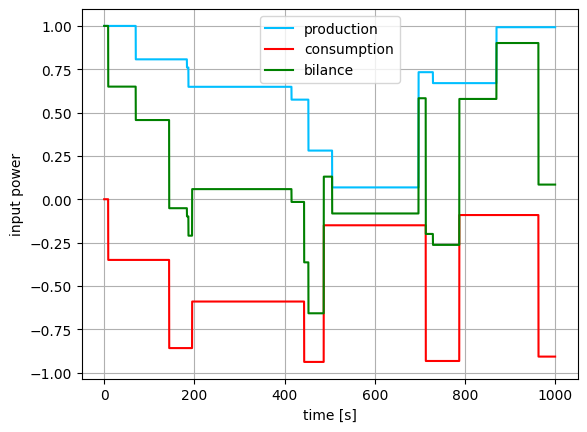

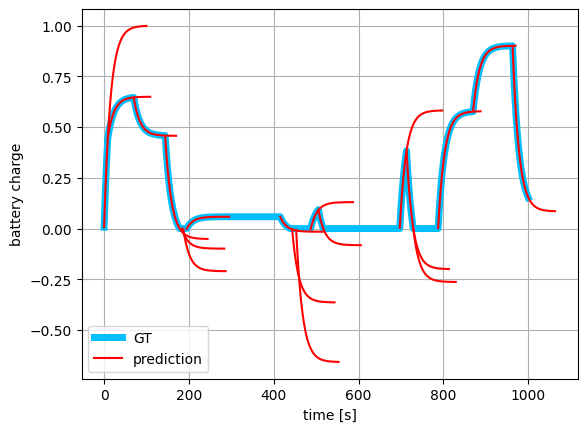

In [138]:
n_max = 10000


#battery state
x = numpy.zeros((mat_a.shape[0], 1))

#kalman prediction
x_hat = numpy.zeros((mat_a.shape[0], 1))

#result log
t_result = []
u_result = []
x_result = []
x_hat_result = []

predicition_result = []
predicition_t_result = []


u_prod = 0.0
u_cons = 0.0

u_prod = 1.0
u_cons = 0.0

for n in range(n_max):

    u_prod_prev = u_prod
    u_cons_prev = u_cons

    #if n > n_max//2:
    #    u_cons = -0.5
    
    if numpy.random.rand() < 0.001:
        u_prod = numpy.random.rand()

    if numpy.random.rand() < 0.001:
        u_cons = -numpy.random.rand()
    

    
    u_tmp = u_prod + u_cons
    u = numpy.ones((1, 1))*u_tmp


    if n == 0 or numpy.abs(u_prod - u_prod_prev) > 0.01 or numpy.abs(u_cons - u_cons_prev) > 0.01:
        steps = 1000
        prediction = kalman_predict(mat_a_disc, mat_b_disc, x_hat, u, steps)
        predicition_result.append(prediction[:, 0])
        predicition_t_result.append(dt*numpy.arange(steps) + n*dt)

    #compute plant output
    #primitive euler method for integration
    dx = mat_a@x + mat_b@u
    x+= dx*dt

    
    x = numpy.clip(x, 0.0, 10**10)

    e = x - x_hat
    x_hat = mat_a_disc@x_hat + mat_b_disc@u + kalman_gain@e

    t_result.append(n*dt)
    u_result.append([u_prod, u_cons, u_tmp])
    x_result.append(x[:, 0].copy())
    x_hat_result.append(x_hat[:, 0].copy())


u_result = numpy.array(u_result)

plt.clf()
plt.plot(t_result, u_result[:, 0], color="deepskyblue", label="production")
plt.plot(t_result, u_result[:, 1], color="red", label="consumption")
plt.plot(t_result, u_result[:, 2], color="green", label="bilance")
plt.xlabel("time [s]")
plt.ylabel("input power")
plt.legend()
plt.grid()
plt.show()


plt.clf()
plt.plot(t_result, x_result, color="deepskyblue", label="GT", linewidth=5.0)
#plt.plot(t_result, x_hat_result, color="purple", label="filtered")

for p in range(len(predicition_result)):
    t = predicition_t_result[p]
    v = predicition_result[p]

    t = numpy.array(t)
    v = numpy.array(v)

    if p == 0:
        plt.plot(t, v, color="red", label="prediction")
    else:
        plt.plot(t, v, color="red")

plt.xlabel("time [s]")
plt.ylabel("battery charge")
plt.legend()
plt.grid()
plt.show()


